In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.constants import e
import numba as nb
import matplotlib.pyplot as plt
import time
from scipy.optimize import fsolve
from tqdm.auto import tqdm
%config InlineBackend.figure_formats = ['svg']

## Thermal detector

In [10]:
def det(T, t, C, Gb, Tb, G, P):
    
    dT = P(t)  # heat input
    dT += Gb * (Tb - T)  # coupling to temperature bath
    dT += np.dot(G, T)  # heat transfer from other components
    dT -= np.dot(np.diag(np.dot(G, np.ones(T.shape[0]))),T)  # heat transfer to other components
    dT /= C  # heat to temperature

    return dT

In [11]:
# def det_ana(T, t, C, Gb, Tb, G, lamb, P):
#     # analytical 2D formulation for cross check - matches
    
#     dT = P(t)  # heat input
#     dT += Gb * (Tb - T)  # coupling to temperature bath
#     dT[0] += G[0,1] * (T[1] - T[0])  # this is the different part
#     dT[1] -= G[0,1] * (T[1] - T[0])  # this is the different part
#     dT /= C  # heat to temperature

#     return dT

In [109]:
C = np.array([0.1, 
              10,
              50])  # heat capacity 
Gb = np.array([100, 
               10,
               100]) # heat cond to bath
Tb = 0  # temp bath
Gab = 10
Gbc = 1
G = np.array([[0, Gab, 0], 
              [Gab, 0, Gbc], 
              [0, Gbc, 0], ])  # heat cond between components
lamb = 0.01  # thermalization time
eps = 0.1  # share in thermometer
eps_ = np.array([eps, 
                 2*eps, 
                 (1-3*eps)])

def P(x):
    return eps_*np.exp(-x/lamb) 

t = np.linspace(0,0.1,10000)
# t = np.logspace(-4,0,10000)

T0 = Tb * np.ones(C.shape[0])

In [110]:
%time T = odeint(det, T0, t, args=(C, Gb, Tb, G, P))

CPU times: user 15.1 ms, sys: 3.49 ms, total: 18.5 ms
Wall time: 15.7 ms


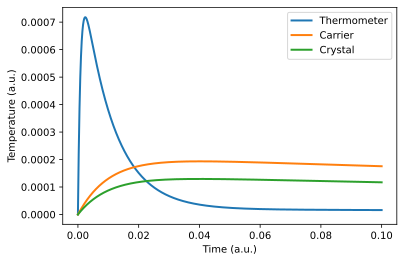

In [114]:
plt.plot(t, T[:, 0], label='Thermometer', c='C0', linewidth=2)
plt.plot(t, T[:, 1], label='Carrier', c='C1', linewidth=2)
plt.plot(t, T[:, 2], label='Crystal', c='C2', linewidth=2)
plt.legend()
plt.xlabel('Time (a.u.)')
plt.ylabel('Temperature (a.u.)')
plt.show()

## Full detector

In [312]:
class DetectorModule:
    
    def __init__(self, 
                 record_length=16384, 
                 sample_frequency=25000,
                 C = np.array([10000, 50000]),  # keV / K
                 Gb = np.array([1000000, 1000000]), # keV / s / K
                 G = np.array([[0, 10000], 
                           [10000, 0],  
                          ]),  # heat cond between components, keV / s / K
                 lamb = 0.005,  # thermalization time (s)
                 eps = np.array([0.2, (1-0.2),]),  # share thermalization in components
                 Rs = np.array([0.04]),  # Ohm
                 Rh = np.array([0.1]),  # Ohm
                 Rt0 = 0.2,  # Ohm
                 L = np.array([3.5e-7]),  # H
                 k = 1000,  # 1/K
                 Tc = 0.015,  # K
                 Ib = 5e2,  # A
                 dac = np.array([5000]),  # V^2
                 pulser_scale = np.array([e*1e3/0.005]),  # scale factor
                 tes_flag = np.array([True, False], dtype=bool),  # which component is a tes
                 heater_flag = np.array([False, True], dtype=bool),  # which component has a heater
                 t0 = .05,  # onset of the trigger, s
                 pileup_prob = 0.02,  # percent / record window
                 tpa_queue = np.array([0.1, 1, 10, -1]),  # V^2
                 tp_interval = 2,  # s
                 max_buffer_len = 100000,
                 dac_ramping_speed = np.array([10]), # V / s
                 Ib_ramping_speed = np.array([10]), # A / s
                 xi = np.array([1]),  # squid conversion current to voltage, V / A
                ): 
        
        # TODO init time dependent variables (Tb, Ib; from timer or t)
        # TODO fix for multiple channels
        # TODO include temp dependence of heat capacity and couplings
        # TODO include calculation of heat capacity and coupling from material constants
        # TODO include noise
        
        self.C = C
        self.Gb = Gb
        self.G = G
        self.lamb = lamb
        self.eps = eps
        self.Rs = Rs 
        self.Rh = Rh 
        self.Rt0 = Rt0 
        self.L = L
        self.k = k 
        self.Tc = Tc 
        self.Ib = Ib 
        self.dac = dac 
        self.pulser_scale = pulser_scale 
        self.tes_flag = tes_flag
        self.heater_flag = heater_flag
        self.record_length = record_length
        self.sample_frequency = sample_frequency
        self.t0 = t0
        self.pileup_prob = pileup_prob
        self.tpa_queue = tpa_queue
        self.tp_interval = tp_interval
        self.max_buffer_len = max_buffer_len
        self.dac_ramping_speed = dac_ramping_speed
        self.Ib_ramping_speed = Ib_ramping_speed
        self.xi = xi

        self.nmbr_components = len(self.C)
        self.nmbr_tes = len(self.Rs)
        self.nmbr_heater = len(self.Rh)
        self.t = np.arange(0,record_length/sample_frequency,1/sample_frequency)  # s
        self.tpa_idx = 0
        self.timer = 0
        self.T = self.Tb(0)*np.ones((self.record_length, self.nmbr_components))
        self.Il, self.It = self.currents(self.T[:, self.tes_flag])
        self.squid_out = self.xi * self.Il
        
        self.buffer_offset = []
        self.buffer_ph = []
        self.buffer_rms = []
        self.buffer_dac = []
        self.buffer_Ib = []
        self.buffer_tpa = []
        self.buffer_timer = []
        
    # setter and getter
    
    def set_control(self, dac, Ib):
        self.dac = np.array(dac)
        self.Ib = np.array(Ib)
        
    def get_buffer(self, name):
        return np.array(eval('self.buffer_' + name))
    
    def get_record(self):
        return np.array(self.Ib)
    
    # public
            
    def wait(self, seconds, update_T=True):
        self.timer += seconds
        if update_T:
            self.pileup_t0 = None
            self.pileup_er = 0
            self.er = 0
            self.tpa = 0
            self.t = np.linspace(0,seconds,self.record_length)
            
            TIb = odeint(self.dTdItdt, 
                            np.concatenate((self.T[-1,:],self.It[-1].reshape(-1))), 
                            self.t, args=(self.C, self.Gb, self.Tb, self.G, self.P, self.Rs, self.Ib, self.Rt, self.L))
            self.T = TIb[:, :self.nmbr_components]
            self.It = TIb[:, self.nmbr_components:]
            self.Il = self.Ib - self.It
            self.squid_out = self.xi * self.Il
            
            self.calc_par()
        
    def trigger(self, er, tpa, verb=False, store=True, time_passes=True):
        if np.random.uniform() < self.pileup_prob:
            self.pileup_t0 = np.random.choice(self.t)
            self.pileup_er = self.pileup_er_distribution()
        else:
            self.pileup_t0 = None
            self.pileup_er = 0
        if verb:
            print(f'T0 is {self.T[-1, :]} K.')
        self.er = er
        self.tpa = tpa
        self.t = np.arange(0,self.record_length/self.sample_frequency,1/self.sample_frequency)
        start = time.time()
        
        TIb = odeint(self.dTdItdt, 
                        np.concatenate((self.T[-1,:],self.It[-1].reshape(-1))), 
                        self.t, args=(self.C, self.Gb, self.Tb, self.G, self.P, self.Rs, self.Ib, self.Rt, self.L),
                    tcrit=np.linspace(self.t0, self.t0 + self.record_length/8/self.sample_frequency, 5))
        self.T = TIb[:, :self.nmbr_components]
        self.It = TIb[:, self.nmbr_components:]
        self.Il = self.Ib - self.It
        self.squid_out = self.xi * self.Il
        
        self.calc_par()
        if verb:
            print(f'Calculated in {time.time() - start} s.')
        if store:
            self.append_buffer()
        if time_passes:
            self.timer += self.t[-1]
            
    def sweep_dac(self, start, end):
        dac_values = []
        for s,e in zip(start,end):
            dac_values.append(np.arange(s, e, np.sign(e - s)*self.dac_ramping_speed[0]*self.tp_interval))
        for dac in tqdm(zip(*dac_values)):
            self.dac = np.array(dac)
            self.trigger(er=0, tpa=self.tpa_queue[self.tpa_idx], 
                         verb=False, store=True, time_passes=True)
            self.wait(seconds=self.tp_interval - self.t[-1])
            self.tpa_idx += 1
            if self.tpa_idx + 1 > len(self.tpa_queue):
                self.tpa_idx = 0
                
    def sweep_Ib(self, start, end):
        Ib_values = []
        for s,e in zip(start,end):
            Ib_values.append(np.arange(s, e, np.sign(e - s)*self.Ib_ramping_speed[0]*self.tp_interval))
        for Ib in tqdm(zip(*Ib_values)):
            self.Ib = np.array(Ib)
            self.trigger(er=0, tpa=self.tpa_queue[self.tpa_idx], 
                         verb=False, store=True, time_passes=True)
            self.wait(seconds=self.tp_interval - self.t[-1])
            self.tpa_idx += 1
            if self.tpa_idx + 1 > len(self.tpa_queue):
                self.tpa_idx = 0
                
    def send_testpulses(self, nmbr_tp=1):
        for i in range(nmbr_tp):
            self.trigger(er=0, tpa=self.tpa_queue[self.tpa_idx], 
                         verb=False, store=True, time_passes=True)
            self.wait(seconds=self.tp_interval - self.t[-1])
            self.tpa_idx += 1
            if self.tpa_idx + 1 > len(self.tpa_queue):
                self.tpa_idx = 0
    
    def start_server():
        pass  # TODO
    
    def clear_buffer(self):
        self.buffer_offset = []
        self.buffer_ph = []
        self.buffer_rms = []
        self.buffer_dac = []
        self.buffer_Ib = []
        self.buffer_tpa = []
        self.buffer_timer = []
    
    def plot_event(self, tes_channel=0, heater_channel=0):  # TODO make work with more components/tes/heaters
        
        t_ch = np.arange(self.nmbr_components)[self.tes_flag][tes_channel]
        h_ch = np.arange(self.nmbr_components)[self.heater_flag][heater_channel]
        
        fig, axes = plt.subplots(2,2, figsize=(10,6))

        axes[0,0].plot(self.t, 1000*self.T[:, 0], label='Thermometer', zorder=10, c='C0', linewidth=2)
        axes[0,0].set_ylabel('Temperature (mK)', color='C0')
        axes[0,0].set_xlabel('Time (s)')
        axes[0,0].legend(loc='upper right').set_zorder(100)
        axes[0,0].set_zorder(10)
        axes[0,0].set_frame_on(False)
        axes[0,0].tick_params(axis='y', labelcolor='C0')
        ax00_2 = axes[0,0].twinx()
        ax00_2.plot(self.t, 1000*self.T[:, 1], label='Crystal', c='C1', linewidth=2)
        ax00_2.set_ylabel('Temperature (mK)', color='C1')
        ax00_2.legend(loc='center right').set_zorder(100)
        ax00_2.tick_params(axis='y', labelcolor='C1')

        # axes[0,1].plot(self.t, self.Il, label='Coil', zorder=10, c='red', linewidth=2)
        axes[0,1].plot(self.t, self.squid_out, label='Squid output', zorder=5, c='black', linewidth=1, alpha=0.7)
        axes[0,1].plot(self.t, self.squid_out, label='Recoil signature', zorder=10, c='red', linewidth=2, alpha=1)
        # axes[0,1].set_ylabel('Current (A)', color='red')
        axes[0,1].set_ylabel('Voltage (V)')  # , color='red'
        axes[0,1].set_xlabel('Time (s)')
        axes[0,1].legend(loc='upper right').set_zorder(100)
        axes[0,1].set_zorder(10)
        # axes[0,1].set_frame_on(False)
        # axes[0,1].tick_params(axis='y', labelcolor='red')
        # ax01_2 = axes[0,1].twinx()
        # ax01_2.plot(self.t, self.It, label='TES', c='C2', linewidth=2)
        # ax01_2.set_ylabel('Current (A)', color='C2')
        # ax01_2.legend(loc='center right').set_zorder(100)
        # ax01_2.tick_params(axis='y', labelcolor='C2')
        
        Tmin, Tmax = np.min(self.T[:, t_ch]), np.max(self.T[:, t_ch])
        Rmin, Rmax = self.Rt(Tmin), self.Rt(Tmax)
        temp = np.linspace(np.minimum(self.Tc - 2/self.k, Tmin), np.maximum(self.Tc + 2/self.k, Tmax), 100)
        axes[1,0].plot(1000*temp, 1000*self.Rt(temp), label='Transition curve', c='#FF7979', linewidth=2)
        axes[1,0].axvline(x=self.Tb(0)*1e3, color='grey', linestyle='dashed', label='Heat bath')
        axes[1,0].fill_between([1000*Tmin, 1000*Tmax], 
                               [0,0], 
                               [1000*Rmin, 1000*Rmax], color='#99CCFF', alpha=0.5, zorder=10)
        axes[1,0].fill_between([1000*temp[0], 1000*Tmin, 1000*Tmax], 
                               [1000*Rmin, 1000*Rmin, 1000*Rmax], 
                               [1000*Rmax, 1000*Rmax, 1000*Rmax], color='#99CCFF', alpha=0.5, zorder=10)
        axes[1,0].plot([1000*temp[0], 1000*Tmin], [1000*Rmin, 1000*Rmin], color='black',  # alpha=0.5, 
                       linewidth=2, label='OP', zorder=100)
        axes[1,0].plot([1000*temp[0], 1000*Tmax], [1000*Rmax, 1000*Rmax], color='black',  # alpha=0.5, 
                       linewidth=2, zorder=100)
        axes[1,0].plot([1000*Tmin, 1000*Tmin], [0, 1000*Rmin], color='black',  # alpha=O.5, 
                       linewidth=2, zorder=100)
        axes[1,0].plot([1000*Tmax, 1000*Tmax], [0, 1000*Rmax], color='black',  # alpha=0.5, 
                       linewidth=2, zorder=100)
        axes[1,0].set_ylabel('Resistance (mOhm)', c='#FF7979')
        axes[1,0].set_xlabel('Temperature (mK)')
        axes[1,0].legend().set_zorder(100)
        axes[1,0].tick_params(axis='y', labelcolor='#FF7979')
        
        power_input = map(self.P, self.t, self.T, self.It)  # for i in range(self.t.shape[0])]
        power_input = np.array(list(power_input))
        axes[1,1].plot(self.t, 0.001*power_input[:,0], color='blue', label='Thermometer', zorder=10, linewidth=2, alpha=0.6)
        axes[1,1].set_ylabel('Heat input (MeV / s)', color='blue')
        axes[1,1].set_xlabel('Time (s)')
        axes[1,1].legend().set_zorder(100)
        axes[1,1].set_zorder(10)
        axes[1,1].set_frame_on(False)
        axes[1,1].tick_params(axis='y', labelcolor='blue')
        ax11_2 = axes[1,1].twinx()
        # axes[1,1].get_shared_y_axes().join(axes[1,1], ax11_2)
        ax11_2.plot(self.t, 0.001*power_input[:,1], color='orange', label='Crystal', linewidth=2)
        ax11_2.set_ylabel('Heat input (MeV / s)', color='orange')
        ax11_2.legend(loc='center right').set_zorder(100)
        ax11_2.tick_params(axis='y', labelcolor='orange')
        
        fig.tight_layout()
        plt.show()
        
    def plot_buffer(self, tes_channel=0, heater_channel=0, tpa=None):
        
        buffer_Ib = self.get_buffer('Ib')
        buffer_dac = self.get_buffer('dac')
        buffer_ph = self.get_buffer('ph')
        buffer_timer = self.get_buffer('timer')
        buffer_tpa = self.get_buffer('tpa')
        
        if tpa is not None:
            buffer_Ib = buffer_Ib[buffer_tpa == tpa]
            buffer_dac = buffer_dac[buffer_tpa == tpa]
            buffer_ph = buffer_ph[buffer_tpa == tpa]
            buffer_timer = buffer_timer[buffer_tpa == tpa]
            buffer_tpa = buffer_tpa[buffer_tpa == tpa]
        
        fig, axes = plt.subplots(2,2, figsize=(10,6))

        axes[0,0].scatter(buffer_dac, buffer_ph, 
                    s=5, marker='o', edgecolor='black', color='white')
        axes[0,0].set_xlabel('DAC (V^2)')
        axes[0,0].set_ylabel('PH (A)')

        axes[0,1].scatter(buffer_timer, buffer_ph, 
                    s=5, marker='o', edgecolor='black', color='white')
        axes[0,1].set_xlabel('Timer (s)')
        axes[0,1].set_ylabel('PH (A)')

        axes[1,0].scatter(buffer_Ib, buffer_ph, 
                    s=5, marker='o', edgecolor='black', color='white')
        axes[1,0].set_xlabel('Ib (A)')
        axes[1,0].set_ylabel('PH (A)')

        colors_ph = (buffer_ph - np.min(buffer_ph))/np.max(buffer_ph)
        reds = plt.get_cmap('Reds')

        axes[1,1].scatter(buffer_Ib, buffer_dac, 
                    s=10, marker='o', color=reds(colors_ph))
        axes[1,1].set_xlabel('Ib (A)')
        axes[1,1].set_ylabel('DAC (V^2)')

        plt.tight_layout()
        plt.show()
    
    # time dependent variables
    
    @staticmethod
    def Tb(t):
        T = 0.0135  # temp bath
        return T
    
    def P(self, t, T, It, no_pulses=False):
        joule_to_keV = 1e-3 / e
        if t > self.t0 and not no_pulses:
            P = self.er*self.eps*np.exp(-(t-self.t0)/self.lamb)/self.lamb # particle
        else:
            P = np.zeros(T.shape)
        if self.pileup_t0 is not None and t > self.pileup_t0 and not no_pulses:
            P += self.pileup_er*self.eps*np.exp(-(t-self.pileup_t0)/self.lamb)/self.lamb # particle
        P[self.tes_flag] += self.Rt(T[self.tes_flag]) * It ** 2  # self heating
        P[self.heater_flag] += self.dac /self.Rh * joule_to_keV # heating
        if t > self.t0 and not no_pulses:
            P[self.heater_flag] += np.maximum(self.tpa, 0)*self.pulser_scale*np.exp(-(t-self.t0)/self.lamb)/self.Rh * joule_to_keV   # test pulses
        return P
    
    # private
        
    @staticmethod
    def dTdt(T, t, C, Gb, Tb, G, P):
        dT = P(t, T)  # heat input
        dT += Gb * (Tb(t) - T)  # coupling to temperature bath
        dT += np.dot(G, T)  # heat transfer from other components
        dT -= np.dot(np.diag(np.dot(G, np.ones(T.shape[0]))),T)  # heat transfer to other components
        dT /= C  # heat to temperature
        return dT
    
    # @staticmethod
    def dTdItdt(self, TIt, t, C, Gb, Tb, G, P, Rs, Ib, Rt, L):
        nmbr_components = C.shape[0]
        dTdIt = np.zeros(nmbr_components + Ib.shape[0])
        T = TIt[:nmbr_components]
        It = TIt[nmbr_components:]
        
        dTdIt[:nmbr_components] = P(t, T, It)  # heat input
        dTdIt[:nmbr_components] += Gb * (Tb(t) - T)  # coupling to temperature bath
        dTdIt[:nmbr_components] += np.dot(G, T)  # heat transfer from other components
        dTdIt[:nmbr_components] -= np.dot(np.diag(np.dot(G, np.ones(T.shape[0]))),T)  # heat transfer to other components
        dTdIt[:nmbr_components] /= C  # heat to temperature
        
        dTdIt[nmbr_components:] = Rs*Ib  # 
        dTdIt[nmbr_components:] -= It*(Rt(T[self.tes_flag]) + Rs)  # 
        dTdIt[nmbr_components:] /= L  # voltage to current
        
        return dTdIt
    
    def Rt(self, T):
        # return self.Rt0/(1 + np.exp(-self.k*(T-self.Tc)))
        R = np.zeros(T.shape)
        R[T > self.Tc - 1/self.k] = self.Rt0*(T[T > self.Tc - 1/self.k] - self.Tc + 1/self.k)/(0.002)
        R[T > self.Tc + 1/self.k] = self.Rt0
        return R
    
    @staticmethod
    def pileup_er_distribution():
        return np.random.uniform(0,1000)  # in keV
    
    def heating(self):
        heating = np.zeros(self.nmbr_components)
        heating[self.heater_flag] = self.dac/self.Rh
        return heating
    
    def self_heating(self, T):
        heating = np.zeros(self.nmbr_components)
        heating[self.tes_flag] = self.Rt(T[self.tes_flag]) * (self.Ib/(1+self.Rt(T[self.tes_flag])/self.Rs)) ** 2
        return heating
    
    def currents(self, Tt):  # TODO make work with more components/tes/heaters
        Rs = self.Rs
        Il, It = np.zeros(Tt.shape), np.zeros(Tt.shape)
        R_tes = self.Rt(Tt)
        Il[R_tes > 0] = self.Ib * (1/(1 + Rs/R_tes[R_tes > 0]))
        It[R_tes > 0] = self.Ib * (1/(1 + R_tes[R_tes > 0]/Rs))
        It[R_tes <= 0] = self.Ib
        return Il, It
        
    def calc_par(self):  # TODO make work with more components/tes/heaters
        self.offset = np.mean(self.Il[self.t < self.t0])
        self.ph = np.max(self.Il - self.offset)
        self.rms = np.std(self.Il[self.t < self.t0])
        
    def calc_par_(self):  # TODO make work with more components/tes/heaters
        self.offset = np.mean(self.Il[:,self.t < self.t0], axis=1)
        self.ph = np.max(self.Il - self.offset, axis=1)
        self.rms = np.std(self.Il[:,self.t < self.t0], axis=1)
        
    def append_buffer(self):
        self.buffer_offset.append(self.offset)
        self.buffer_ph.append(self.ph)
        self.buffer_rms.append(self.rms)
        self.buffer_dac.append(self.dac)
        self.buffer_Ib.append(self.Ib)
        self.buffer_tpa.append(self.tpa)
        self.buffer_timer.append(self.timer)
        
        for ls in [self.buffer_offset, self.buffer_ph, self.buffer_rms, 
                  self.buffer_dac, self.buffer_Ib, self.buffer_tpa,
                  self.buffer_timer]:
            while len(ls) > self.max_buffer_len:
                del ls[0]
            

In [332]:
det = DetectorModule(record_length=16384, 
                     sample_frequency=25000,
                     C = np.array([10000, 50000]),  # keV / K
                     Gb = np.array([1000000, 1000000]), # keV / s / K
                     G = np.array([[0, 10000], 
                               [10000, 0],  
                              ]),  # heat cond between components, keV / s / K
                     lamb = 0.005,  # thermalization time (s)
                     eps = np.array([0.2, (1-0.2),]),  # share thermalization in components
                     Rs = np.array([0.04]),  # Ohm
                     Rh = np.array([0.1]),  # Ohm
                     Rt0 = 0.2,  # Ohm
                     L = np.array([3.5e-7]),  # H
                     k = 1000,  # 1/K
                     Tc = 0.015,  # K
                     Ib = 5e2,  # A
                     dac = np.array([5000]),  # V^2
                     pulser_scale = np.array([e*1e3/0.005]),  # scale factor
                     tes_flag = np.array([True, False], dtype=bool),  # which component is a tes
                     heater_flag = np.array([False, True], dtype=bool),  # which component has a heater
                     t0 = .16,  # onset of the trigger, s
                     pileup_prob = 0.02,  # percent / record window
                     tpa_queue = np.array([0.1, 1, 10, -1]),  # V^2
                     tp_interval = 2,  # s
                     max_buffer_len = 100000,
                     dac_ramping_speed = np.array([10]), # V / s
                     Ib_ramping_speed = np.array([10]), # A / s
                    )

In [333]:
det.set_control([e*1e3], [5e2])

In [334]:
det.wait(5)

In [341]:
det.trigger(er=0, tpa=100, verb=True)

T0 is [0.01528951 0.01353767] K.
Calculated in 0.04947304725646973 s.


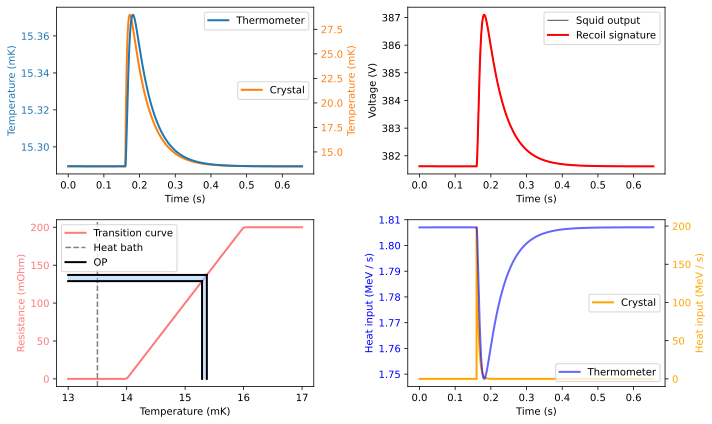

In [342]:
det.plot_event()

In [293]:
# dac sweep
det = DetectorModule(record_length=16384, 
                     sample_frequency=25000,
                     pileup_prob=0, 
                     dac_ramping_speed = np.array([20]),
                     tpa_queue = np.array([10, 100, 500, -1]),
                    )
det.clear_buffer()
start_time = time.time()
for Ib in np.linspace(7e2, 3e2, 5):
    print('Ib: {}, time passed: {} mins'.format(Ib, (time.time() - start_time)/60))
    det.set_control([0], [Ib])
    det.sweep_dac([10000], [0])

Ib: 700.0, time passed: 5.849202473958334e-06 mins


0it [00:00, ?it/s]

Ib: 600.0, time passed: 0.1115568995475769 mins


0it [00:00, ?it/s]

Ib: 500.0, time passed: 0.2818663994471232 mins


0it [00:00, ?it/s]

Ib: 400.0, time passed: 0.5179999669392904 mins


0it [00:00, ?it/s]

Ib: 300.0, time passed: 0.7383556326230367 mins


0it [00:00, ?it/s]

In [8]:
# bias sweep
det = DetectorModule(record_length=16384, 
                     sample_frequency=25000,
                     pileup_prob=0, 
                     Ib_ramping_speed = np.array([1]),
                     tpa_queue = np.array([10, 100, 500, -1]),
                     
                    )
det.clear_buffer()
det.set_control([5000], [7e2])
det.sweep_Ib([700], [300])


0it [00:00, ?it/s]

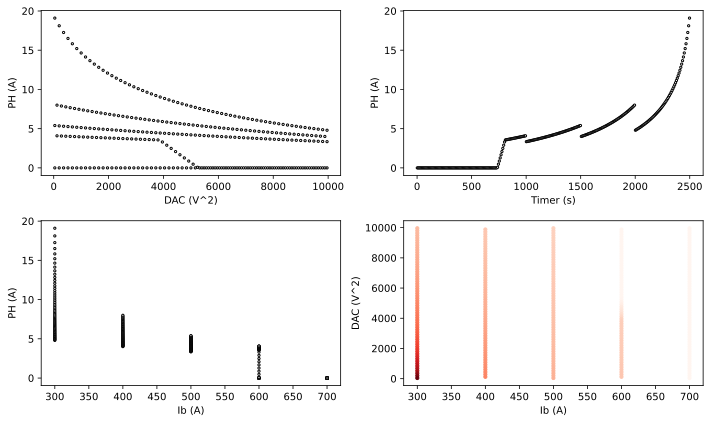

In [294]:
det.plot_buffer(tpa=100)